<a href="https://colab.research.google.com/github/tanoManzo/mimic_attitude/blob/dev/AnnoAgreement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Annotation Agrement Evaluation

In [ ]:
!pip install krippendorff

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Data Import**

donwloaded from physionet

In [ ]:
import pandas as pd
import numpy as np

# import data
df_notes_dina = pd.read_json('/content/drive/MyDrive/NIH/Data/annotated_burnout/dina.jsonl', lines=True)
df_notes_lj = pd.read_json('/content/drive/MyDrive/NIH/Data/annotated_burnout/lj.jsonl', lines=True)
df_notes_rory = pd.read_json('/content/drive/MyDrive/NIH/Data/annotated_burnout/rory.jsonl', lines=True)
df_notes_admin = pd.read_json('/content/drive/MyDrive/NIH/Data/annotated_burnout/admin.jsonl', lines=True)
df_notes_yasmeen = pd.read_json('/content/drive/MyDrive/NIH/Data/annotated_burnout/yasmeen.jsonl', lines=True)
df_notes_original_data = df_notes_dina[['id', 'text', 'row_id']]

print(df_notes_original_data.columns)

Index(['id', 'text', 'row_id'], dtype='object')


# **Loop Version**

In [ ]:
# merge dataframes, dataframe setup (same as Non-Loop version below)
df_notes = [df_notes_dina, df_notes_lj, df_notes_rory, df_notes_yasmeen, df_notes_admin]
new_col_names = ['Dina', 'Lj', 'Rory', 'Yasmeen', 'Admin']

sentiment_data = df_notes[0].iloc[20:].reset_index(drop=True)[['id', 'cats']].rename(columns={'cats': new_col_names[0]})

for i in range(0, len(df_notes)):
  if i > 0:
    sentiment_data = pd.merge(sentiment_data, 
                        df_notes[i].iloc[20:][['id', 'cats']].rename(columns={'cats': new_col_names[i]}), 
                        on='id')  
  sentiment_data[new_col_names[i]] = sentiment_data[new_col_names[i]].apply(lambda x: x[0])  #  if len(x) > 0 else 0 (if missing data use this)
  sentiment_data[new_col_names[i]] = sentiment_data[new_col_names[i]].replace(
      {'Overall Positive Note': 1, 
       'Overall Negative Note': -1, 
       'Overall Neutral Note': 0}
  )

# print(sentiment_data)

# **Step by Step Version**



In [ ]:
# dataframe setup step by step

In [ ]:
# remove first 20 rows and unneeded columns
df_notes_dina = df_notes_dina.iloc[20:][['id','cats']].reset_index(drop=True)
df_notes_lj = df_notes_lj.iloc[20:][['id','cats']].reset_index(drop=True)
df_notes_rory = df_notes_rory.iloc[20:][['id','cats']].reset_index(drop=True)
df_notes_yasmeen = df_notes_yasmeen.iloc[20:][['id','cats']].reset_index(drop=True)
#df_notes_admin = df_notes_admin.iloc[20:][['id','cats']].reset_index(drop=True)

In [ ]:
# grab first value of overall note list
def get_first_value(lst):
  if len(lst) == 0:  # fix empty list values
    return 'Overall Neutral Note'
  return lst[0]

df_notes_dina['cats'] = df_notes_dina['cats'].apply(get_first_value)
df_notes_lj['cats'] = df_notes_lj['cats'].apply(get_first_value)
df_notes_rory['cats'] = df_notes_rory['cats'].apply(get_first_value)
df_notes_admin['cats'] = df_notes_admin['cats'].apply(get_first_value)
df_notes_yasmeen['cats'] = df_notes_yasmeen['cats'].apply(get_first_value)

In [ ]:
def mapping_sentiment_to_ints(labels):
  mapping = {'Overall Positive Note': 1, 'Overall Negative Note': -1, 'Overall Neutral Note': 0}
  return labels.map(lambda x: mapping[x])

# simplify note values
df_notes_dina['cats'] = mapping_sentiment_to_ints(df_notes_dina['cats'])
df_notes_lj['cats'] = mapping_sentiment_to_ints(df_notes_lj['cats'])
df_notes_rory['cats'] = mapping_sentiment_to_ints(df_notes_rory['cats'])
df_notes_admin['cats'] = mapping_sentiment_to_ints(df_notes_admin['cats'])
df_notes_yasmeen['cats'] = mapping_sentiment_to_ints(df_notes_yasmeen['cats'])

In [ ]:
# create one dataframe for all sentiment
df_notes_dina = df_notes_dina.rename(columns={'cats': 'Dina'})
df_notes_lj = df_notes_lj.rename(columns={'cats': 'Lj'})
df_notes_rory = df_notes_rory.rename(columns={'cats': 'Rory'})
df_notes_admin = df_notes_admin.rename(columns={'cats': 'Admin'})
df_notes_yasmeen = df_notes_yasmeen.rename(columns={'cats': 'Yasmeen'})

# this should produce the same results as the looped 'sentiment-data' variable
merged_df = df_notes_dina.merge(df_notes_lj, on='id').merge(df_notes_rory, on='id').merge(df_notes_yasmeen, on='id').merge(df_notes_admin, on='id')
# print(merged_df)

# **Combining notes**

In [ ]:
import json

def mapping_sentiment_to_strings(labels):
  mapping = {1:'Overall Positive Note', -1: 'Overall Negative Note', 0: 'Overall Neutral Note'}
  return labels.map(lambda x: mapping[x] if not pd.isna(x) else pd.NA)

top_sentiment_data = sentiment_data.copy()
top_sentiment_data[['mode1','mode2']] = sentiment_data.mode(axis=1, dropna=False)
top_sentiment_data['mode1'] = mapping_sentiment_to_strings(top_sentiment_data['mode1'])
top_sentiment_data['mode2'] = mapping_sentiment_to_strings(top_sentiment_data['mode2'])
top_sentiment_data['mode'] = top_sentiment_data.apply(lambda x: [x['mode1'], x['mode2']] if not pd.isna(x['mode2']) else [x['mode1']], axis=1)
top_sentiment_data = top_sentiment_data.rename(columns={'mode': 'sentiment'})
merged_notes = pd.merge(top_sentiment_data.drop(columns=['Dina', 'Lj', 'Rory', 'Yasmeen', 'Admin', 'mode1', 'mode2'], axis=1), df_notes_original_data, on='id')
merged_notes_json = merged_notes.to_json(orient='records')

#with open('merged_notes_json', 'w') as f:
  #json.dump(merged_notes_json, f)

#print(merged_notes.head(35).to_string(index=False))
#print(top_sentiment_data.to_string(index=False))
#print(merged_notes.columns)
#print(merged_notes[~top_sentiment_data['mode2'].isna()])


# **Annotator Agreement Methods**

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from itertools import combinations
import statistics as stat

In [ ]:
# All possible pairs with regard for "ground truth"
annotators = sentiment_data.columns[1:]
rater_pairs = list(combinations(annotators, 2))
f1_scores = []
for r1, r2 in rater_pairs:
  y_true = sentiment_data[r1]  # or use 'merged_df' if modifying step by step version
  y_pred = sentiment_data[r2]  # or use 'merged_df' if modifying step by step version
  averages = ['macro', 'micro', 'weighted']
  for average in averages:
    precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred, average=average)
    if average == 'weighted': f1_scores.append(f1_score)
    #print(f'Pair {r1}-{r2} (avg={average}): F1_score={f1_score:.2f}, precision={precision:.2f}, recall={recall:.2f}')
    precision, recall, f1_score, support = precision_recall_fscore_support(y_pred, y_true, average=average)
    if average == 'weighted': f1_scores.append(f1_score)
    #print(f'Pair {r2}-{r1} (avg={average}): F1_score={f1_score:.2f}, precision={precision:.2f}, recall={recall:.2f}\n')

print(f'Max f1 score: {max(f1_scores):.2f}; Min f1 score: {min(f1_scores):.2f}; Avg f1 score: {sum(f1_scores) / len(f1_scores):.2f}; Median f1 score: {stat.median(f1_scores):.2f}')
    

Max f1 score: 0.85; Min f1 score: 0.45; Avg f1 score: 0.63; Median f1 score: 0.64


In [ ]:
# find full agreement
sentiments = [-1, 1]
sentiments_dict = {1:'Overall Positive Note', -1:'Overall Negative Note', 0:'Overall Neutral Note'}
for sentiment in sentiments:
  mask = (sentiment_data.iloc[:,1:] == sentiment)
  pd.set_option('display.max_colwidth', None)
  print('\n' + sentiments_dict[sentiment])
  print(f'Index(es): {merged_df[mask.all(axis=1)].index.tolist()}')
  print('Example:')
  print(merged_df[mask.all(axis=1)].head(1).to_string(index=False))


Overall Negative Note
Index(es): [10, 21, 148, 153, 168]
Example:
 id  Dina  Lj  Rory  Yasmeen                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

# **Other Agreement Methods**

In [ ]:
from statsmodels.stats.inter_rater import fleiss_kappa
from sklearn.metrics import cohen_kappa_score
from itertools import combinations
import krippendorff

# Fleiss
table = sentiment_data.iloc[:,1:].apply(pd.value_counts, axis=1).fillna(0).values
fleiss = fleiss_kappa(table)
print(f"Fleiss' kappa: {fleiss:.3f}")

# Cohens
columns = sentiment_data.columns[1:]
rater_pairs = list(combinations(columns, 2))
kappas = []
for r1, r2 in rater_pairs:
  kappa = cohen_kappa_score(sentiment_data[r1], sentiment_data[r2])
  kappas.append(kappa)
print(f"Cohens' kappa: {sum(kappas)/len(kappas):.3f}")

# Krippendorff
data = sentiment_data.iloc[:,1:].values.T
kd_result = krippendorff.alpha(data, level_of_measurement='nominal')
print(f"Krippendorff alpha: {kd_result:.3f}")

Fleiss' kappa: 0.257
Cohens' kappa: 0.264
Krippendorff alpha: 0.258


# **Graphical Display**

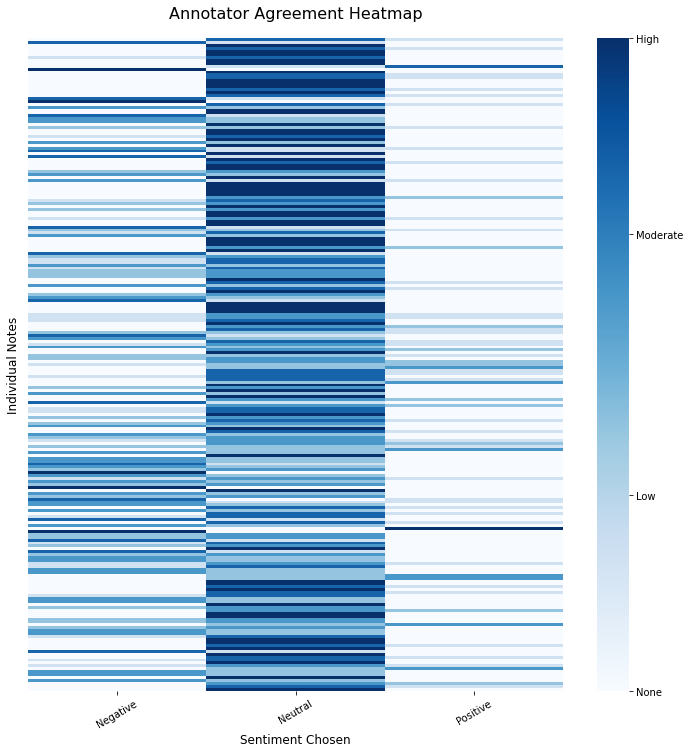

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# heatmap
df_table = pd.DataFrame(sentiment_data.iloc[:,1:].apply(pd.value_counts, axis=1).fillna(0).values, 
                        columns=['Negative', 'Neutral', 'Positive'])
fig, ax = plt.subplots(figsize=(12, 12))
heatmap = sns.heatmap(df_table, cmap='Blues', ax=ax, yticklabels=False) #, cbar_kws={'label': 'Number of Annotators', 'orientation': 'horizontal', 'pad':0.15}
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=30)

# color bar
cbar = heatmap.collections[0].colorbar
cbar.set_ticks([0, 1.5, 3.5, 5])
cbar.set_ticklabels(['None', 'Low', 'Moderate', 'High'])

plt.title('Annotator Agreement Heatmap', fontsize=16, pad=20)
plt.xlabel('Sentiment Chosen', fontsize=12)
plt.ylabel('Individual Notes', fontsize=12)
plt.show()

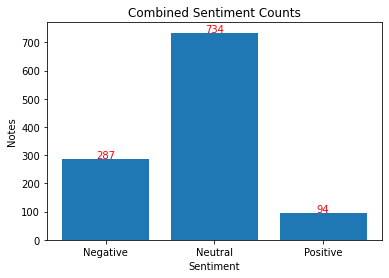

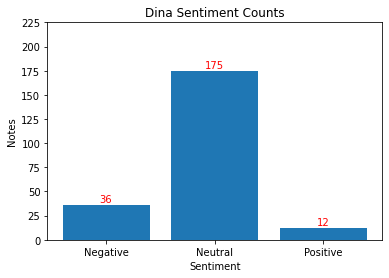

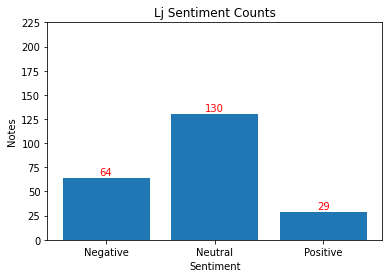

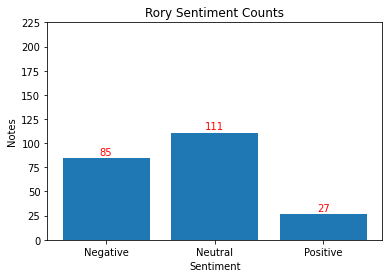

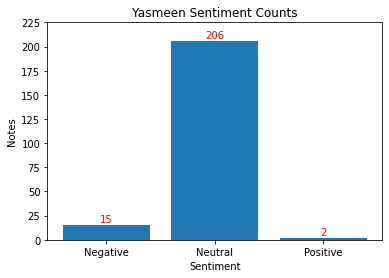

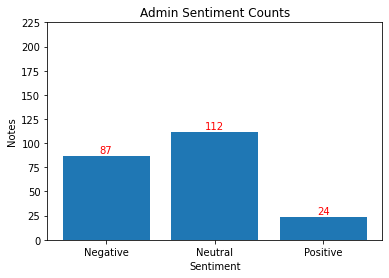

In [ ]:
# bar graph
labels = ['Negative', 'Neutral', 'Positive']
data = sentiment_data.iloc[:,1:].values
counts = np.unique(data, return_counts=True)
plt.bar(labels, counts[1])
plt.xlabel('Sentiment')
plt.ylabel('Notes')
plt.title('Combined Sentiment Counts')
for i, val in enumerate(counts[1]):
  plt.text(i, val + 3, str(val), horizontalalignment='center', color='r')
plt.show()

annotators = sentiment_data.columns[1:]
for annotator in annotators:
  anno_data = sentiment_data[annotator].value_counts().sort_index()
  plt.bar(labels, anno_data)
  plt.xlabel('Sentiment')
  plt.ylabel('Notes')
  plt.ylim(top=225)
  plt.title(f'{annotator} Sentiment Counts')
  for i, val in enumerate(anno_data):
    plt.text(i, val + 3, str(val), horizontalalignment='center', color='r')
  plt.show()

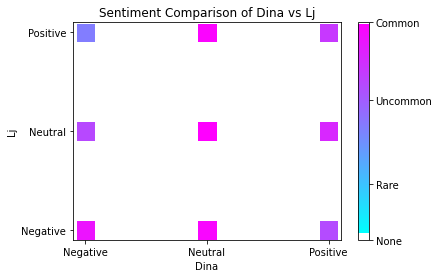

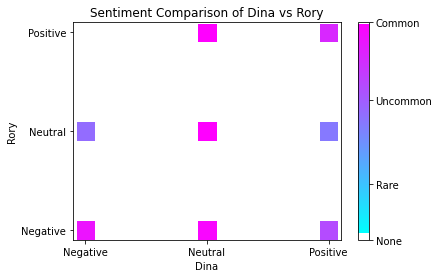

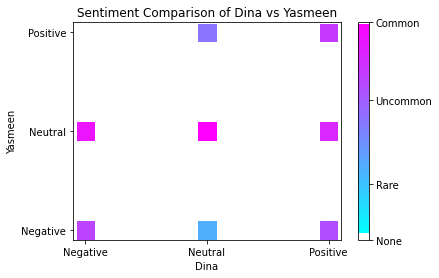

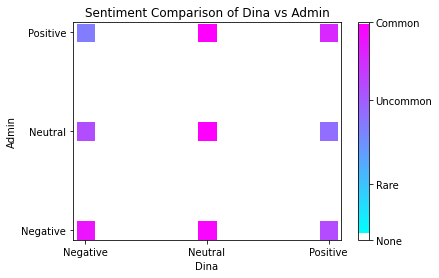

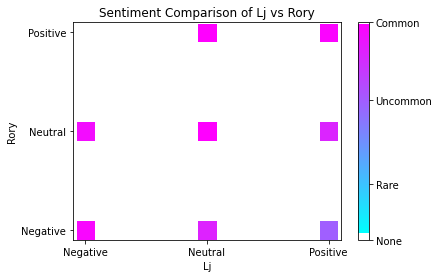

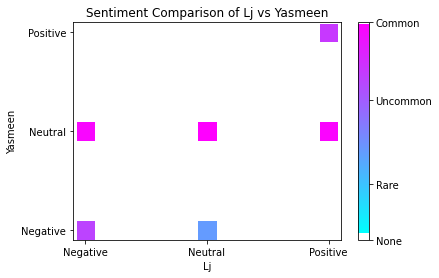

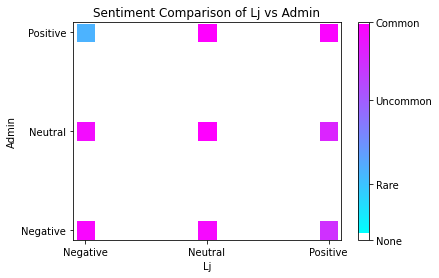

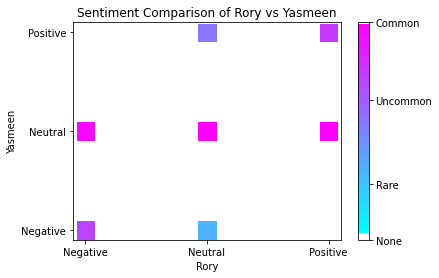

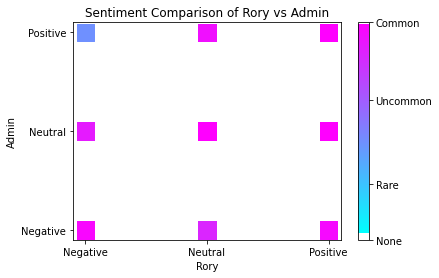

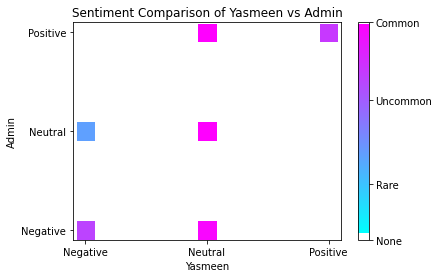

In [ ]:
# scatter plots
for i, r1 in enumerate(sentiment_data.columns[1:]):
  for j, r2 in enumerate(sentiment_data.columns[1:]):
    if i < j:
      fig, ax = plt.subplots()
      scatter = ax.scatter(sentiment_data[r1], sentiment_data[r2], 
                           c=sentiment_data.mean(axis=1), cmap='cool',
                           marker='s', s=300)
      ax.set_xlabel(r1)
      ax.set_xticks([-1, 0, 1])
      ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
      ax.set_ylabel(r2)
      ax.set_yticks([-1, 0, 1])
      ax.set_yticklabels(['Negative', 'Neutral', 'Positive'])
      ax.set_title(f'Sentiment Comparison of {r1} vs {r2}')
      cbar = plt.colorbar(scatter)
      cbar.set_ticks([110, 120, 135, 149])
      cbar.set_ticklabels(['None', 'Rare', 'Uncommon', 'Common'])
      plt.show()

# **Saved Code**

In [ ]:
# boxplots
# doesn't look particularly useful...
#data = sentiment_data.iloc[:,1:]
#print(data)
#fig, ax = plt.subplots(figsize=(10,6))
#ax.boxplot(data)
#ax.set_xticklabels(sentiment_data.columns[1:])
#ax.set_xlabel('Annotators')
#ax.set_ylabel('Rating')
#ax.set_title(f'Box Plot of Ratings')
#plt.show()


In [ ]:
#!pip install interank
#import interank
#dir(interank)
# did not work...

In [ ]:
#!pip install pygamma-agreement
#from pygamma_agreement import cohen_kappa, fleiss_kappa, krippendorff_alpha
#import pygamma_agreement
#dir(pygamma_agreement)
# did not work...

In [ ]:
# Krippendorff
#kd_result2 = krippendorff.alpha([[0,1,2],[0,1,2],[0,1,2]], level_of_measurement='nominal')
#correct_list = [[1,1,1],[2,2,2],[0,0,0]]
#kd_result3 = krippendorff.alpha(list(zip(*correct_list)))
#print(f"Krippendorff alpha 2: {kd_result2:.2f}")
#print(f"Krippendorff alpha 3: {kd_result3:.2f}")

In [ ]:
# Does not include all pairs
#annotators = ['lj', 'rory']
#ground_truth = 'dina'

#for annotator in annotators:
#  y_true = sentiment_data[ground_truth]  # or use 'merged_df'
#  y_pred = sentiment_data[annotator]  # or use 'merged_df'
#  averages = ['macro', 'micro', 'weighted']
#  for average in averages:
#    precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred, average=average)
#    # print(f'Annotator {annotator} (avg={average}): F1_score={f1_score:.2f}, precision={precision:.2f}, recall={recall:.2f}')